<h1><b>LOGISTIC REGRESSION FOR BANK MARKETING DATASET</b></h1>
<i><b>Dataset : https://archive.ics.uci.edu/ml/datasets/Bank+Marketing</b></i>

This logistic Regression using MLlib is created using the reference tutorial created by <b>Juliet Hougland</b>. The GitHub code which this is based on is https://github.com/hougs/ds-for-telco/blob/master/ds-for-telco.ipynb

In [50]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
import os
import seaborn as sb
import matplotlib.pyplot as plt

In [51]:
# sc = SparkContext(appName='bankLoanAnalysis')
sql_context = SQLContext(sc)
schema = StructType([
    StructField('age', DoubleType(), True),
    StructField('job', StringType(), True),
    StructField('martial', StringType(), True),
    StructField('education', StringType(), True),
    StructField('default', StringType(), True),
    StructField('hosting', StringType(), True),
    StructField('loan', StringType(), True),
    StructField('contact', StringType(), True),
    StructField('month', StringType(), True),
    StructField('day_of_week', StringType(), True),
    StructField('duration', DoubleType(), True),
    StructField('campaign', DoubleType(), True),
    StructField('pdays', DoubleType(), True),
    StructField('previous', DoubleType(), True),
    StructField('p_outcome', StringType(), True),
    StructField('empvarrate', DoubleType(), True),
    StructField('conspriceidx', DoubleType(), True),
    StructField('consconfidx', DoubleType(), True),
    StructField('euribor3m', DoubleType(), True),
    StructField('nremployed', DoubleType(), True),
    StructField('y', StringType(), True)])

In [52]:
numeric_cols = ['age',
                'duration',
                'campaign',
                'pdays',
                'previous',
                'empvarrate',
                'conspriceidx',
                'consconfidx',
                'euribor3m',
                'nremployed']
categorical_cols = ['job',
                    'martial',
                    'education',
                    'default',
                    'hosting',
                    'loan',
                    'contact',
                    'month',
                    'day_of_week',
                    'p_outcome']
dir_name = '/home/dennis/Documents/Cloud\ Computing/Project/Spark_Linear_Regression/'
churn_data = sql_context.read\
    .format('com.databricks.spark.csv')\
    .load(os.path.join(dir_name, 'dataset', 'bank-additional', 'bank-additional.csv'),
          schema=schema)

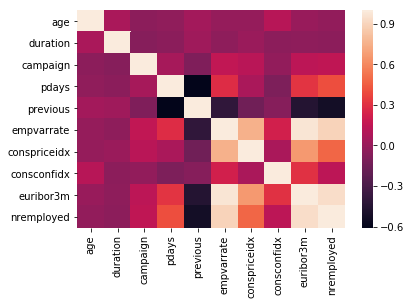

In [53]:
sample_data = churn_data.sample(False, 0.5, 83).toPandas()
corr = sample_data[numeric_cols].corr()
heat_map = sb.heatmap(corr)
plt.show(heat_map)

In [54]:
reduced_numeric_cols = ['age',
                          'duration',
                          'campaign',
                          'pdays',
                          'previous',
                          'empvarrate',
                          'conspriceidx',
                          'consconfidx'
                         ]

In [55]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

label_indexer = StringIndexer(inputCol = 'y', outputCol = 'label')
assembler = VectorAssembler(
    inputCols = reduced_numeric_cols,
    outputCol = 'features')

In [56]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

classifier = LogisticRegression(regParam=0.01, labelCol = 'label', featuresCol = 'features')

pipeline = Pipeline(stages=[label_indexer, assembler, classifier])

(train, test) = churn_data.randomSplit([0.7, 0.3])
model = pipeline.fit(train)

In [60]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
raw = evaluator.evaluate(predictions)
"The AUROC is %s and the AUPR is %s and raw is %s." % (auroc, aupr, raw)

'The AUROC is 0.911083977750646 and the AUPR is 0.513134381317285 and raw is 0.911083977750646.'